In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np

In [2]:
df=pd.read_parquet("ori_df.parquet")
df.columns

Index(['Tail_Number', 'prev_arr_dt', 'prev_arr_delay', 'prev_origin',
       'prev_dest', 'prev_crs_dep', 'prev_crs_arr', 'next_dep_dt', 'DepDelay',
       'next_origin', 'Dest', 'next_crs_dep', 'next_crs_arr', 'turn_time_min',
       'O-D', 'historical_turn_time_min_3mean', 'scheduled_turn_time',
       'realized slack', 'scheturn_bucket', 'prev_bin', 'op_carrier',
       'op_flight', 'Origin', 'carrier_slope', 'origin_slope', 'crsdep_hour',
       'dep_hour', 'prev_arr_hour', 'datetime', 'temperature_2m',
       'wind_speed_10m', 'wind_gusts_10m', 'precipitation', 'is_day',
       'cloud_cover', 'airport', 'datetime_pa', 'temperature_2m_pa',
       'wind_speed_10m_pa', 'wind_gusts_10m_pa', 'precipitation_pa',
       'is_day_pa', 'cloud_cover_pa', 'airport_pa', 'Distance',
       'DistanceGroup', 'CRSElapsedTime', 'DayOfWeek', 'dep_dt', 'FlightDate',
       'crsdep_tbin', 'prev_arr_tbin'],
      dtype='object')

In [3]:
y_label= "DepDelay"

numeric_cols = [
'prev_arr_delay',
 'historical_turn_time_min_3mean',
 'scheduled_turn_time',
 'realized slack',
 'carrier_slope',
 'origin_slope',
 'temperature_2m',
 'wind_speed_10m',
 'wind_gusts_10m',
 'precipitation',
 'cloud_cover',
 'temperature_2m_pa',
 'wind_speed_10m_pa',
 'wind_gusts_10m_pa',
 'precipitation_pa',
 'cloud_cover_pa',
 'Distance',
 'CRSElapsedTime',
]

cat_cols=[
 'prev_origin',
#  'prev_crs_arr',
 'Dest',
 'scheturn_bucket',
 'prev_bin',
 'op_carrier',
 'Origin',
#  'crsdep_hour',
 'prev_arr_tbin',
 'crsdep_tbin',
 'is_day',
'is_day_pa',
'DistanceGroup',
 'DayOfWeek']



Features Engineering:

In [ ]:
import numpy as np
import pandas as pd

def add_advanced_features(df):
    df = df.copy()
    df["FlightDate"] = pd.to_datetime(df["FlightDate"])
    df = df.sort_values("FlightDate")


    df["slack_time"] = df["scheduled_turn_time"] - df["historical_turn_time_min_3mean"]

    df["prev_arr_delay_clip"] = df["prev_arr_delay"].clip(lower=-30, upper=180)

    df["scheduled_turn_capped"] = df["scheduled_turn_time"].clip(lower=5, upper=180)

    df["prop_prev_delay_over_planned_turn"] = (
        df["prev_arr_delay_clip"] / df["scheduled_turn_capped"]
    )

    df["prop_prev_delay_over_turn"] = df["prev_arr_delay_clip"] / (df["scheduled_turn_time"] + 1e-3)

    df["short_turn"] = (df["scheduled_turn_time"] < 45).astype(int)
    df["short_turn_prev_delay"] = df["short_turn"] * df["prev_arr_delay_clip"]


    df["wind_speed_diff"] = df["wind_speed_10m"] - df["wind_speed_10m_pa"]
    df["wind_gusts_diff"] = df["wind_gusts_10m"] - df["wind_gusts_10m_pa"]
    df["temp_diff"]       = df["temperature_2m"] - df["temperature_2m_pa"]
    df["precip_diff"]     = df["precipitation"] - df["precipitation_pa"]
    df["cloud_diff"]      = df["cloud_cover"] - df["cloud_cover_pa"]

    df["has_rain"]    = (df["precipitation"] > 0.1).astype(int)
    df["has_rain_pa"] = (df["precipitation_pa"] > 0.1).astype(int)


    df = df.sort_values(["Origin", "FlightDate"])
    df["origin_delay_mean_7d"] = (
        df.groupby("Origin")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=3).mean())
    )

    df = df.sort_values(["op_carrier", "FlightDate"])
    df["carrier_delay_mean_7d"] = (
        df.groupby("op_carrier")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=3).mean())
    )

    df["Route"] = df["Origin"].astype(str) + "_" + df["Dest"].astype(str)
    df = df.sort_values(["Route", "FlightDate"])
    df["route_delay_mean_7d"] = (
        df.groupby("Route")["DepDelay"]
          .transform(lambda x: x.shift().rolling(window=7, min_periods=5).mean())
    )

    global_mean_delay = df["DepDelay"].mean()
    for col in ["origin_delay_mean_7d", "carrier_delay_mean_7d", "route_delay_mean_7d"]:
        df[col] = df[col].fillna(global_mean_delay)


    df["avg_speed"] = df["Distance"] / (df["CRSElapsedTime"] + 1e-3)
    df["prev_big_delay"] = (df["prev_arr_delay"] >= 30).astype(int)

    return df


In [ ]:
df = add_advanced_features(df)


advanced_numeric = [
    "slack_time",
    "prev_arr_delay_clip",
    "prop_prev_delay_over_turn",
    "short_turn_prev_delay",
    "wind_speed_diff",
    "wind_gusts_diff",
    "temp_diff",
    "precip_diff",
    "cloud_diff",
    "origin_delay_mean_7d",
    "carrier_delay_mean_7d",
    "route_delay_mean_7d",
    "avg_speed",
]

advanced_cat = [
    "short_turn",      
    "has_rain",
    "has_rain_pa",
    # "Route",
    "prev_big_delay",
]

numeric_cols_extended = numeric_cols + advanced_numeric
cat_cols_extended     = cat_cols + advanced_cat

features_extended = numeric_cols_extended + cat_cols_extended


In [ ]:


import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

y_label = "DepDelay"

df_model = df.copy()
df_model = df_model[df_model[y_label].notna()].copy()#make sure y not nan
df_model["FlightDate"] = pd.to_datetime(df_model["FlightDate"])
df_model = df_model.sort_values("FlightDate")

）
train_end = "2025-01-21"
valid_end = "2025-01-28"

train = df_model[df_model["FlightDate"] <= train_end]
valid = df_model[(df_model["FlightDate"] > train_end) & (df_model["FlightDate"] <= valid_end)]
test  = df_model[df_model["FlightDate"] > valid_end]

X_train_raw, y_train = train[features_extended], train[y_label]
X_valid_raw, y_valid = valid[features_extended], valid[y_label]
X_test_raw,  y_test  = test[features_extended],  test[y_label]

print("Train:", X_train_raw.shape, "Valid:", X_valid_raw.shape, "Test:", X_test_raw.shape)



Train: (287832, 47) Valid: (96362, 47) Test: (42071, 47)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor


def eval_regression(y_true, y_pred, name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"MAE : {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²  : {r2:.3f}")
    return mae, rmse, r2
    
num_processor = Pipeline([
    ("imputer_num", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_processor = Pipeline([
    ("imputer_cat", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor_rf = ColumnTransformer([
    ("num", num_processor, numeric_cols_extended),
    ("cat", cat_processor, cat_cols_extended),
])


preprocessor_rf.fit(X_train_raw)


X_train_rf = preprocessor_rf.transform(X_train_raw)
X_valid_rf = preprocessor_rf.transform(X_valid_raw)
X_test_rf  = preprocessor_rf.transform(X_test_raw)




Optuna: Parameter Tuning

In [ ]:
def objective_rf(trial):
    params = {
    
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 8, 20),  # 
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 8),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.3, 0.5]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "n_jobs": -1,
        "random_state": 42,
    }


    model = RandomForestRegressor(**params)

    model.fit(X_train_rf, y_train)
    pred_valid = model.predict(X_valid_rf)
    mae = mean_absolute_error(y_valid, pred_valid)
    return mae

study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(objective_rf, n_trials=25, show_progress_bar=True)

print("Best MAE:", study_rf.best_value)
print("Best params:", study_rf.best_params)
best_params_rf = study_rf.best_params


[I 2025-12-11 01:01:42,537] A new study created in memory with name: no-name-7a058079-f4d5-4443-90bb-7117ed016152


  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-12-11 01:11:46,349] Trial 0 finished with value: 7.942984093368925 and parameters: {'n_estimators': 111, 'max_depth': 20, 'min_samples_split': 17, 'min_samples_leaf': 6, 'max_features': 0.5, 'bootstrap': True}. Best is trial 0 with value: 7.942984093368925.
[I 2025-12-11 01:14:43,118] Trial 1 finished with value: 8.213867035299302 and parameters: {'n_estimators': 116, 'max_depth': 12, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 0.5, 'bootstrap': False}. Best is trial 0 with value: 7.942984093368925.
[I 2025-12-11 01:14:47,231] Trial 2 finished with value: 15.368750331041284 and parameters: {'n_estimators': 184, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 7.942984093368925.
[I 2025-12-11 01:14:56,377] Trial 3 finished with value: 13.754400007103285 and parameters: {'n_estimators': 215, 'max_depth': 19, 'min_samples_split': 13, 'min_samples_leaf': 5, 'max_features': 'lo

Final Model:

In [ ]:

final_params_rf = best_params_rf.copy()
final_params_rf["n_estimators"] = best_params_rf["n_estimators"] + 200  

rf_final = RandomForestRegressor(
    **final_params_rf,
    n_jobs=-1,
    random_state=42
)


from scipy import sparse
X_full_rf = sparse.vstack([X_train_rf, X_valid_rf])
y_full    = np.concatenate([y_train.values, y_valid.values])

rf_final.fit(X_full_rf, y_full)

y_test_pred_rf = rf_final.predict(X_test_rf)

from sklearn.metrics import root_mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_test_pred_rf)
rmse = root_mean_squared_error(y_test, y_test_pred_rf)
r2   = r2_score(y_test, y_test_pred_rf)

print("\n===== Random Forest Final (Train+Valid) =====")
print(f"Test MAE : {mae:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²  : {r2:.3f}")



===== Random Forest Final (Train+Valid) =====
Test MAE : 8.093
Test RMSE: 20.178
Test R²  : 0.699


Feature Importance:

In [ ]:
import pandas as pd

feat_imp = pd.Series(
    rf_final.feature_importances_,
    index=preprocessor_rf.get_feature_names_out()
)

grouped = {}

for col in numeric_cols_extended:
    name_in_pipeline = f"num__{col}"
    if name_in_pipeline in feat_imp.index:
        grouped[col] = feat_imp[name_in_pipeline]
    else:
      
        pass


for col in cat_cols_extended:
    prefix = f"cat__{col}_"
    cols = [c for c in feat_imp.index if c.startswith(prefix)]
    if len(cols) > 0:
        grouped[col] = feat_imp[cols].sum()
    else:
        # print(f"[warn] categorical col {col} not found with prefix {prefix}")
        pass

grouped_imp = pd.Series(grouped).sort_values(ascending=False)
print(grouped_imp.head(30))


realized slack                    0.452624
prop_prev_delay_over_turn         0.144364
scheduled_turn_time               0.106632
prev_arr_delay                    0.075547
prev_arr_delay_clip               0.062058
slack_time                        0.051575
prev_big_delay                    0.011694
prev_bin                          0.010746
carrier_delay_mean_7d             0.008672
origin_delay_mean_7d              0.006184
route_delay_mean_7d               0.004608
origin_slope                      0.004435
avg_speed                         0.004359
Origin                            0.004077
historical_turn_time_min_3mean    0.003908
Distance                          0.003579
op_carrier                        0.003254
Dest                              0.003025
CRSElapsedTime                    0.002673
temp_diff                         0.002646
prev_origin                       0.002604
temperature_2m                    0.002439
temperature_2m_pa                 0.002436
wind_gusts_

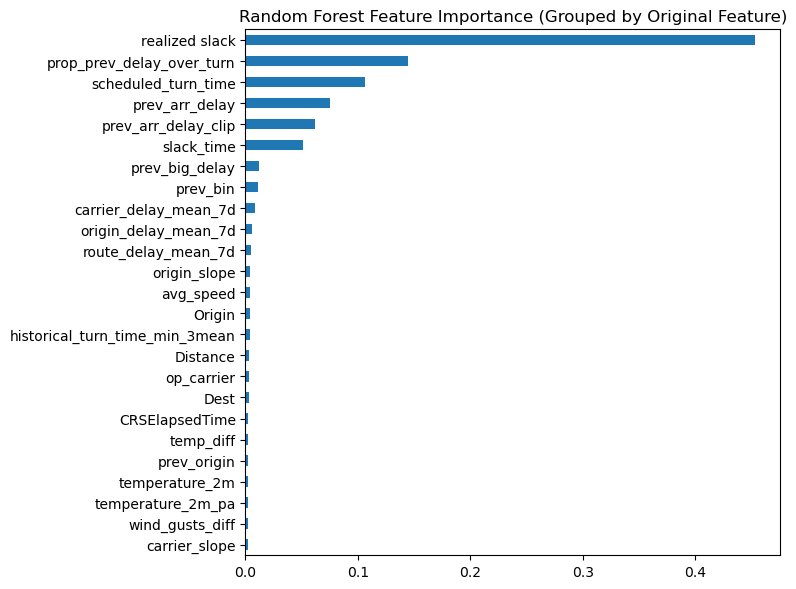

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
grouped_imp.head(25).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance (Grouped by Original Feature)")
plt.tight_layout()
plt.show()
